# Statistical exploration of fluorescent signal

### Load libraries

In [1]:
import pandas as pd
import seaborn as sns
import openpyxl
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

### Local data location

In [5]:
archivo_excel = r"C:\Users\ADMIN\Desktop\ROIs_refinadas\Mean_ROI_values_48000_thr130.xlsx"

df = pd.read_excel(archivo_excel)

# Cargar hoja de Ned(-)
df_neg = pd.read_excel(archivo_excel, sheet_name="Ned(-)")
df_neg["Ned19"] = "Ned(-)"

# Cargar hoja de Ned(+)
df_pos = pd.read_excel(archivo_excel, sheet_name="Ned(+)")
df_pos["Ned19"] = "Ned(+)"

# Unir ambas tablas
df = pd.concat([df_neg, df_pos], ignore_index=True)

print(archivo_excel)

#print(df.columns)   # ahora sí deberías ver "Ned19"

C:\Users\ADMIN\Desktop\ROIs_refinadas\Mean_ROI_values_48000_thr130.xlsx


### Obtaining the means by independent mouse

In [6]:
df_mean = df.groupby(
    ["Organismo","Condición","Ned19"], 
    as_index=False, 
    observed=True
)["Signal_Mass_Norm"].mean()

labels = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"]  # <- list

vals_minus = (df_mean
    .query('Condición == "mib" and Ned19 == "Ned(-)"')    
    .sort_values("Organismo")["Signal_Mass_Norm"]
    .to_numpy())

vals_plus = (df_mean
    .query('Condición == "mib" and Ned19 == "Ned(+)"')    
    .sort_values("Organismo")["Signal_Mass_Norm"]
    .to_numpy())

print("Mib Ned(-):", len(vals_minus), vals_minus)
print("Mib Ned(+):", len(vals_plus), vals_plus)

vals = vals_minus

Mib Ned(-): 8 [ 0.14270137  0.0113209  -0.11491144  0.07692768 -0.14594851 -0.17903509
 -0.41429268 -0.0760926 ]
Mib Ned(+): 8 [ 1.21703854e+00 -1.01109002e-03 -7.28180954e-02 -1.89452145e-01
 -9.64903647e-05 -1.52174844e-02 -7.64178580e-01 -3.48226517e-01]


### Data visualization

Mean = -0.0874, SD = 0.1729, n = 8


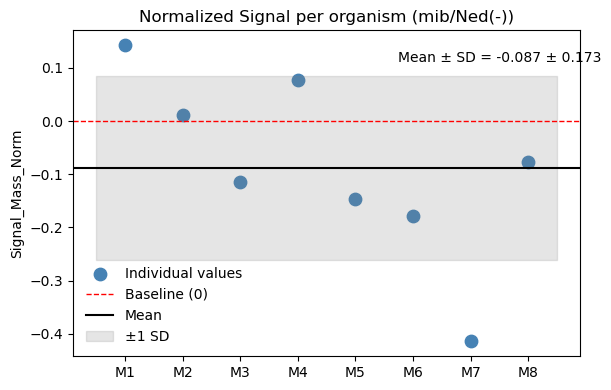

In [7]:
# Descriptive statistics
mean_val = np.mean(vals)
sd_val   = np.std(vals, ddof=1)  # sample SD
n        = len(vals)

print(f"Mean = {mean_val:.4f}, SD = {sd_val:.4f}, n = {n}")

# --------------------------------------------------------------------
# Create figure
plt.figure(figsize=(6, 4))

# Individual points
plt.scatter(np.arange(n), vals, color='steelblue', s=80, label="Individual values")

# Reference line at zero
plt.axhline(0, color='red', linestyle='--', linewidth=1, label="Baseline (0)")

# Mean line and SD shading
plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.5, label="Mean")
plt.fill_between(
    [-0.5, n-0.5],
    mean_val - sd_val,
    mean_val + sd_val,
    color='gray',
    alpha=0.2,
    label='±1 SD'
)
# --------------------------------------------------------------------
# Axes and labels
plt.xticks(np.arange(n), labels)
plt.ylabel("Signal_Mass_Norm")
plt.title("Normalized Signal per organism (mib/Ned(-))")
plt.legend(loc="best", frameon=False)
plt.tight_layout()

# --------------------------------------------------------------------
# Optional annotation of mean ± SD
plt.text(
    n - 1.5,            # x position
    mean_val + sd_val + 0.02,  # y position slightly above SD bar
    f"Mean ± SD = {mean_val:.3f} ± {sd_val:.3f}",
    fontsize=10,
    ha="center",
    va="bottom"
)

#plt.savefig(r"C:\Users\ADMIN\Desktop\ROIs_refinadas\P-hack_scatter_Signal_Mass_Norm_48000_thr130_NedPlus_5.png", dpi=300)
plt.show()

### Plot generation for all conditions with previuos graphical/statistical representation

In [8]:
def _natural_key(s):
    """Natural sort (M1, M2, …, M10)."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', str(s))]

def compute_df_mean(
    df: pd.DataFrame,
    organism_col="Organismo",
    treatment_col="Condición",
    ned_col="Ned19",
    value_col="Signal_Mass_Norm",
):
    """Group by organism × treatment × Ned19 and compute means (observed groups only)."""
    g = (
        df.groupby([organism_col, treatment_col, ned_col], as_index=False, observed=True)[value_col]
          .mean()
    )
    return g

# ---------- main plot ----------

def plot_panels_from_mean(
    df_mean: pd.DataFrame,
    organism_col="Organismo",
    treatment_col="Condición",
    ned_col="Ned19",
    value_col="Signal_Mass_Norm",
    ned_order=("Ned(-)", "Ned(+)"),
    treatment_order=("mib", "iono"),
    organism_labels=None,  # e.g., ["M1", ..., "M8"]; if None, inferred and naturally sorted
    point_size=70,
    show_mean_sd=True,
    sd_alpha=0.15,
    figsize=(10, 8),
    savepath=None,
):
    # Organism order
    if organism_labels is None:
        organism_labels = sorted(df_mean[organism_col].dropna().unique(), key=_natural_key)
    org_idx = pd.Index(organism_labels)
    x_all = np.arange(len(org_idx))

    # Canvas
    fig, axes = plt.subplots(
        nrows=len(treatment_order),
        ncols=len(ned_order),
        sharex=True, sharey=True, figsize=figsize
    )

    # Make axes a 2D array
    if axes.ndim == 1:
        axes = np.atleast_2d(axes)

    for r, treat in enumerate(treatment_order):
        for c, ned in enumerate(ned_order):
            ax = axes[r, c]

            # Subset and pivot to ensure one value per organism (means already computed)
            sub = df_mean.loc[
                (df_mean[treatment_col] == treat) & (df_mean[ned_col] == ned),
                [organism_col, value_col]
            ].copy()

            # Align to full organism index; missing organisms become NaN
            sub = (
                sub.set_index(organism_col)
                   .reindex(org_idx)
                   .rename_axis(organism_col)
            )
            y_full = sub[value_col].to_numpy()

            # Scatter only present points (drop NaNs for plotting, preserve x positions)
            mask = ~np.isnan(y_full)
            x_sub = x_all[mask]
            y = y_full[mask]

            ax.scatter(x_sub, y, s=point_size, label="Individual means")

            # Baseline
            ax.axhline(0.0, linestyle="--", linewidth=1.5, color="red",
                       alpha=0.7, label="Baseline (0)" if (r, c) == (0, 0) else None)

            # Mean ± SD band
            if show_mean_sd and y.size > 0:
                mean = float(np.mean(y))
                sd = float(np.std(y, ddof=1)) if y.size > 1 else 0.0
                ax.axhline(mean, color="black", linewidth=1.5,
                           label="Mean" if (r, c) == (0, 0) else None)
                ax.fill_between([-0.5, len(org_idx) - 0.5],
                                mean - sd, mean + sd,
                                color="gray", alpha=sd_alpha,
                                label="±1 SD" if (r, c) == (0, 0) else None)
                ax.text(0.99, 0.97, f"Mean ± SD = {mean:.3f} ± {sd:.3f}",
                        ha="right", va="top", transform=ax.transAxes)

            # Cosmetics
            ax.set_xlim(-0.5, len(org_idx) - 0.5)
            ax.set_xticks(x_all)
            ax.set_xticklabels(list(org_idx))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
            ax.grid(False)

            # Titles and labels
            ax.set_title(f"{ned} | {treat}")
            if r == len(treatment_order) - 1:
                ax.set_xlabel("Organism (M1…Mn)")
            if c == 0:
                ax.set_ylabel("F/F₀ − 1 (mean)")

    # Legend and layout
    fig.suptitle("Per-organism mean ΔF/F₀ by Ned19 state and treatment", y=0.98, fontsize=14)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=len(labels),
                   frameon=False, bbox_to_anchor=(0.5, 1.02))
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig, axes

# ---------- example workflow (exactly matching your snippet) ----------
# df_mean = compute_df_mean(df,
#                           organism_col="Organismo",
#                           treatment_col="Condición",
#                           ned_col="Ned19",
#                           value_col="Signal_Mass_Norm")
# labels = ["M1","M2","M3","M4","M5","M6","M7","M8"]
# fig, axes = plot_panels_from_mean(
#     df_mean,
#     organism_col="Organismo",
#     treatment_col="Condición",
#     ned_col="Ned19",
#     value_col="Signal_Mass_Norm",
#     ned_order=("Ned(-)", "Ned(+)"),
#     treatment_order=("mib", "iono"),
#     organism_labels=labels,
#     savepath=None  # or "ned_mib_iono_means.png"
# )
# plt.show()

### Display and save plots

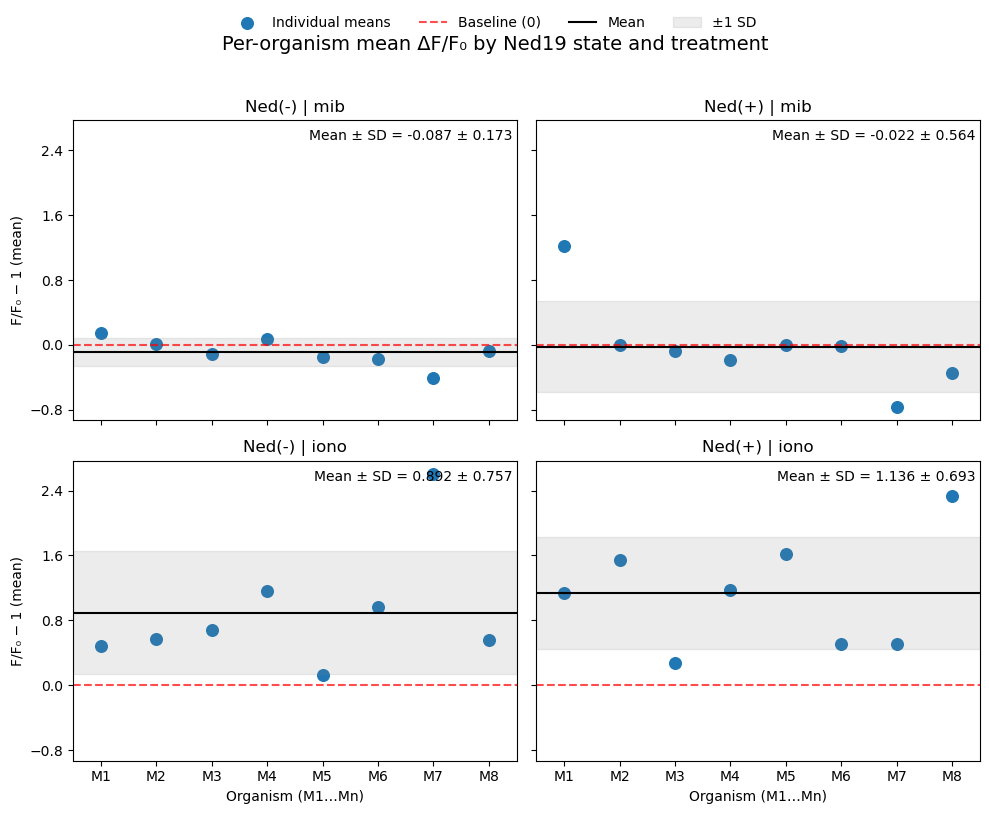

In [9]:
fig, axes = plot_panels_from_mean(
    df_mean,
    organism_col="Organismo",
    treatment_col="Condición",
    ned_col="Ned19",
    value_col="Signal_Mass_Norm",
    ned_order=("Ned(-)", "Ned(+)"),
    treatment_order=("mib", "iono"),
    organism_labels=labels,
    savepath=None  # or "ned_mib_iono_means.png"
)
plt.show()